<a href="https://colab.research.google.com/github/Renan-Domingues/IntroductionToPytorch/blob/main/IntroductionPytorch_05_TensorboardSupport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch TensorBoard Support


### Introduction
This is a varient of the LeNet-5 against Fashion-MNIST dataset.

In [ ]:
# Pytorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# image display
import matplotlib.pyplot as plt
import numpy as np

# pytorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter


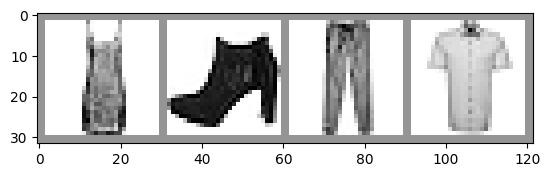

In [ ]:
# Adding  sample images from our dataset to Tensorboard

# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]
)

# Store separate training and validations splits in. /data
training_set = torchvision.datasets.FashionMNIST('.data',
                                                 download=True,
                                                 train=True,
                                                 transform=transform)
validation_set = torchvision.datasets.FashionMNIST('./data',
                                                   download=True,
                                                   train=False,
                                                   transform=transform)

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=2)

validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=4,
                                                shuffle=False,
                                                num_workers=2)

# class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
  if one_channel:
    img = img.mean(dim=0)
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy()
  if one_channel:
    plt.imshow(npimg, cmap="Greys")
  else:
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

Above, we used TorchVisiond and Matplotlib to create a visual grid of minibatch of our imput data.

Now we'll going to use "add_image()" call on "SummaryWriter" to log the image for consumption by TensorBoard, and we'll also call "flush()" to  make sure it's written to disk right away

In [ ]:
#  Default log_dir argument is "runs" - but it's good to be specific
# torch.utils.tensorboard.SummaryWriter is alredy imported
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# Write image data to TensorBoard log dir
writer.add_image('Four Fashion_MNIST Images', img_grid)
writer.flush()

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/

If you start TensorBoard at the command line and open it in a new browser tab (usually at localhost:6006), you should see the image grid under the IMAGES tab.

### Graphing Scalars to Visualize Training

We'll run a training loop, track some metrics, and save the data for TensorBoard's consumption.

In [ ]:
# Define a model  to categorize out image tiles, and a optimizer and loss function for training

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 4 * 4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [ ]:
# Let's train a epoch and evaluate the training vs. validation set losses every 1000 batches

print(len(validation_loader))

for epoch in range(1): # loop over the dataset multiple times
  running_loss = 0.0

  for i, data in enumerate(training_loader, 0):
    # basic training loop
    inputs, labels = data
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 1000 == 999: # every 1000 minibatches
      print(f"Batch {i + 1}")
      # check against the validation set
      running_vloss = 0.0

      net.train(False) # Don't need to track gradents for validation
      for j, vdata in enumerate(validation_loader, 0):
        vinputs, vlabels = vdata
        voutputs = net(vinputs)
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss.item()
      net.train(True) # Turn gradients back on for training

      avg_loss = running_loss / 1000
      avg_vloss = running_vloss / len(validation_loader)

      # log the running loss averaged per batch
      writer.add_scalars('Training vs. Validation Loss',
                         {'Training': avg_loss, 'Validation': avg_vloss},
                         epoch * len(training_loader) + i)
      running_loss = 0.0
print('Finished Training')

writer.flush()

2500
Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000
Batch 6000
Batch 7000
Batch 8000
Batch 9000
Batch 10000
Batch 11000
Batch 12000
Batch 13000
Batch 14000
Batch 15000
Finished Training


### Visualizing Your Model

TensorBoard can also be used to examine the data flow within your model. To do this, call the "add_graph()" method with a model and sample input. When you open

In [ ]:
# grab a single minibatch of image
dataiter = iter(training_loader)
images, labels = next(dataiter)

# add_graph() will trace the sample input through my model and render it as a graph
writer.add_graph(net, images)
writer.flush()


Double-click the “NET” node to see the layers and data flow within my model.

### Visualizing My Dataset with

The 28-by-28 image tiles we're using can be modeled as 784-dimensional vectors (28 * 28 = 784).

The "add_embedding()" method will project a set of data onto the three dimensions with highest variance, and display them as an interactive 3D chart.  The "add_embedding()" do this automatically

Let's generate such an ambedding:


In [ ]:
# Select a random subset of data and corresponding labels

def select_n_random(data, labels, n=100):
  assert len(data) == len(labels)

  perm = torch.randperm(len(data))
  return data[perm][:n], labels[perm][:n]

# extract a random sibset of data
images, labels = select_n_random(training_set.data, training_set.targets)

# get the class labels for each image
class_labels = [classes[label] for label in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))

writer.flush()
writer.close()

Now if I switch to TensorBoard and select the PROJECTOR tab, I should see a 3D representation of the projection.